## Tree Detection with DeepForest

This jupyter notebook uses the python library DeepForest to identify and put bounding boxes around trees. 

If using the software, please cite as: 
Geographic Generalization in Airborne RGB Deep Learning Tree Detection Ben. G. Weinstein, Sergio Marconi, Stephanie A. Bohlman, Alina Zare, Ethan P. White bioRxiv 790071; doi: https://doi.org/10.1101/790071

Documentation for DeepForest can be found at https://deepforest.readthedocs.io/en/latest/index.html

In [1]:
#Install the deepforest python library. After installing, you may need to restart the kernel before moving to the next code snippet
!pip install DeepForest --quiet

In [1]:
##After restarting the kernel, import libraries into environment...
from deepforest import main
from deepforest import get_data
from deepforest.utilities import boxes_to_shapefile
from deepforest.utilities import shapefile_to_annotations
from deepforest.preprocess import split_raster
from deepforest.visualize import plot_predictions

import matplotlib.pyplot as plt
import os
import time
import numpy
import rasterio
import geopandas as gpd
from rasterio.plot import show
import torch


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [2]:
# Ask the shell what GPU we have
!nvidia-smi 

Mon Sep  9 18:38:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A16                     Off |   00000000:A4:00.0 Off |                    0 |
|  0%   21C    P8             12W /   62W |       1MiB /  15356MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# How many GPUs does torch think we have
torch.cuda.device_count()

1

In [4]:
# Is the GPU available for Torch?
torch.cuda.is_available()

True

In [5]:
#Bring a DeepForest pretrained model into environment. It is located at https://github.com/weecology/DeepForest/releases/tag/1.0.0
model = main.deepforest()
model.use_release()

Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /home/jovyan/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 193MB/s]  
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


NEON.pt: 129MB [00:02, 62.9MB/s]                              

Model was downloaded and saved to /opt/conda/lib/python3.11/site-packages/deepforest/data/NEON.pt
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


## Predict Tree Crowns on Raw (non-georeferenced images)

In [6]:
#Path for the image you want to ID trees. These are non-georeferenced single jpeg drone image. In this example, the image data is in Cyverse
image_path = get_data("/data-store/iplant/home/shared/commons_repo/curated/Gillan_Ecosphere_2021/raw_images/May_2019/15-g2/100_0123/100_0123_0086.JPG")
image_path2 = get_data("/data-store/iplant/home/shared/cyverse_training/datalab/nextgen_geospatial/DJI_0184.jpeg")
image_path3 = get_data("/data-store/iplant/home/shared/cyverse_training/datalab/nextgen_geospatial/100_0407_0064.jpeg")
image_path4 = get_data("/data-store/iplant/home/shared/cyverse_training/datalab/nextgen_geospatial/DJI_0468.jpeg")
image_path5 = get_data("/data-store/iplant/home/shared/cyverse_training/datalab/nextgen_geospatial/101_0472_0074.jpeg")

In [7]:
#Identify and put bounding boxes around all trees in the image
#This will create a table showing image coordinates of every predicted tree
#The 'score' is the confidence that the prediction is correct. Values closer to 1 are better. 
trees = model.predict_image(path=image_path2, return_plot = False)
trees

xmin   ymin   xmax   ymax label     score     image_path
0   205.0  442.0  245.0  482.0  Tree  0.482140  DJI_0184.jpeg
1    64.0  347.0  102.0  384.0  Tree  0.456419  DJI_0184.jpeg
2     2.0  137.0   48.0  187.0  Tree  0.444820  DJI_0184.jpeg
3     1.0  332.0   42.0  377.0  Tree  0.438789  DJI_0184.jpeg
4   130.0  496.0  170.0  535.0  Tree  0.432619  DJI_0184.jpeg
..    ...    ...    ...    ...   ...       ...            ...
57  549.0   92.0  589.0  129.0  Tree  0.186831  DJI_0184.jpeg
58  130.0  335.0  171.0  376.0  Tree  0.186490  DJI_0184.jpeg
59   58.0  207.0  110.0  258.0  Tree  0.185045  DJI_0184.jpeg
60  206.0  138.0  248.0  180.0  Tree  0.180048  DJI_0184.jpeg
61  343.0  365.0  427.0  442.0  Tree  0.103841  DJI_0184.jpeg

[62 rows x 7 columns]

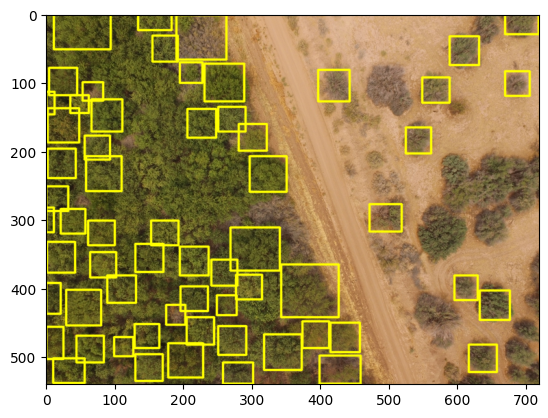

In [8]:
#Show the image with the bounding boxes
plot = model.predict_image(path=image_path2, return_plot = True, color=(0, 255, 255), thickness=2)
plt.imshow(plot[:,:,::-1])

## Predict Tree Crowns on Georeferenced Images

In [9]:
#Set the path for a georeferenced image you want to predict tree crowns
#raster_path = get_data("/data-store/iplant/home/jgillan/media/1a_g2_ortho.tif")
raster_path = get_data("/data-store/iplant/home/shared/cyverse_training/datalab/nextgen_geospatial/hole_17_ortho_utm.tif")

In [10]:
##Predict tree crowns on a georeferenced image
predicted_raster = model.predict_tile(raster_path, return_plot = True, patch_size=1000, patch_overlap=0.25, color=(255, 255, 0), thickness=20)

You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/jovyan/data-store/Geospatial_Workshops/notebooks/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 490/490 [00:44<00:00, 11.11it/s]
5312 predictions in overlapping windows, applying non-max supression
3022 predictions kept after non-max suppression


/opt/conda/lib/python3.11/site-packages/deepforest/visualize.py:118: UserWarning: Input images must be channels last format [h, w, 3] not channels first [3, h, w], using np.rollaxis(image, 0, 3) to invert!
  warnings.warn("Input images must be channels last format [h, w, 3] not channels "


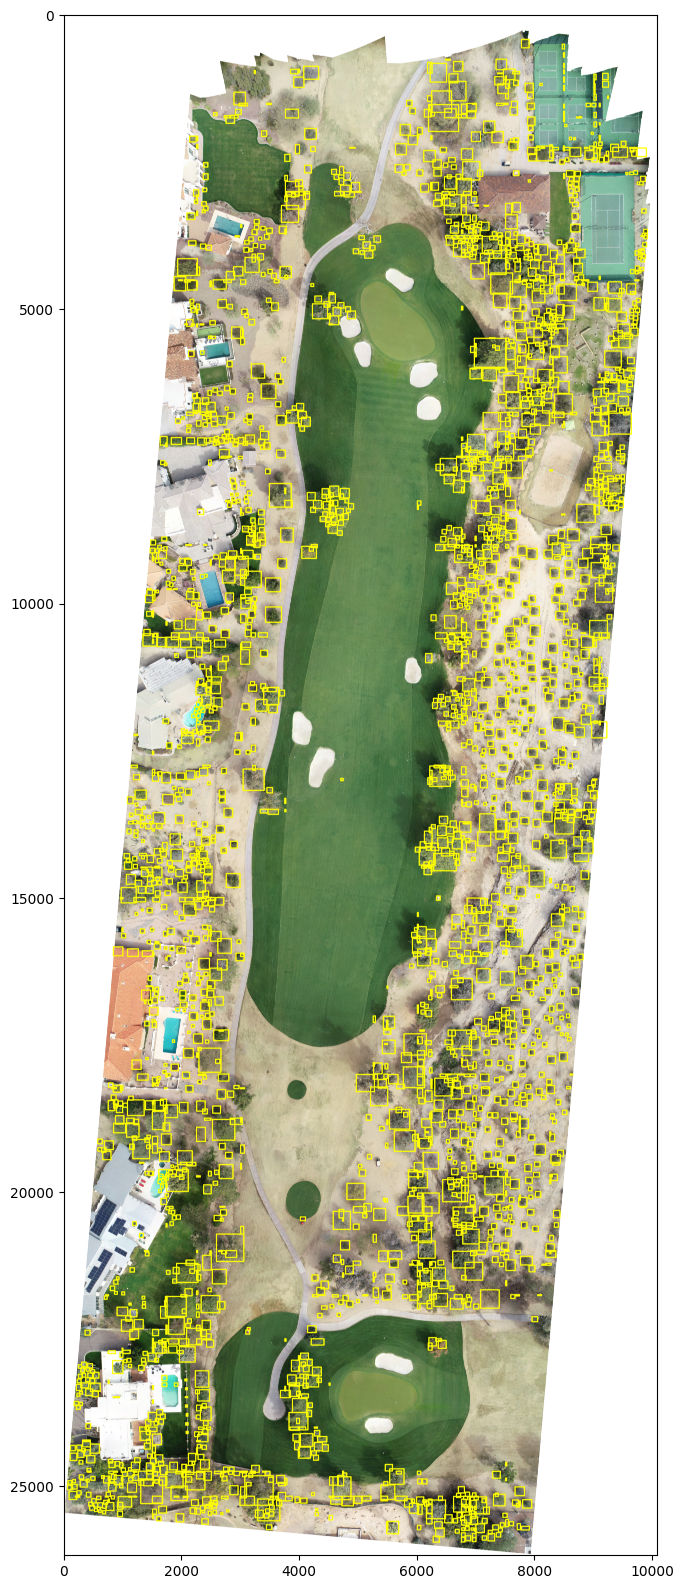

In [11]:
plt.figure(figsize=(20, 20))
plt.imshow(predicted_raster)
plt.show()

## Improve Model with Training
If the pre-trained model does not identify all trees correclty, then we want to improve the model by adding some training data and fine-tuning the model.
Manual labeling of trees (bounding boxes) can be done in QGIS. The output should be a polygon shapefile (.shp). Instructions for using QGIS is [here](https://github.com/ua-datalab/Geospatial_Workshops/wiki/Drone-Image-Analysis-%E2%80%90-Deep-Forest)

In [12]:
#Define data paths in preparation to convert .shp to annotation dataframe that can be used for training
## I have found that it is important that the orthomosaic and shapefiles used should have map projections (e.g., UTM). Otherwise, there will be a shift problem in the `shapefile_to_annotations` step.  

# training data imagery path 
# We are using the golf course orthomosaic geotiff
train_image_path = get_data("/data-store/iplant/home/shared/cyverse_training/datalab/nextgen_geospatial/hole_17_ortho_utm.tif")


# the directory that has the training data imagery
train_image_dir = os.path.dirname(train_image_path)

# the name of the training imagery
image_name = os.path.basename(train_image_path)

# shapefile path
#shp_path = "/data-store/iplant/home/jgillan/media/golf_train_utm.shp"
shp_path = "/data-store/iplant/home/shared/cyverse_training/datalab/nextgen_geospatial/golf_train_utm.shp"

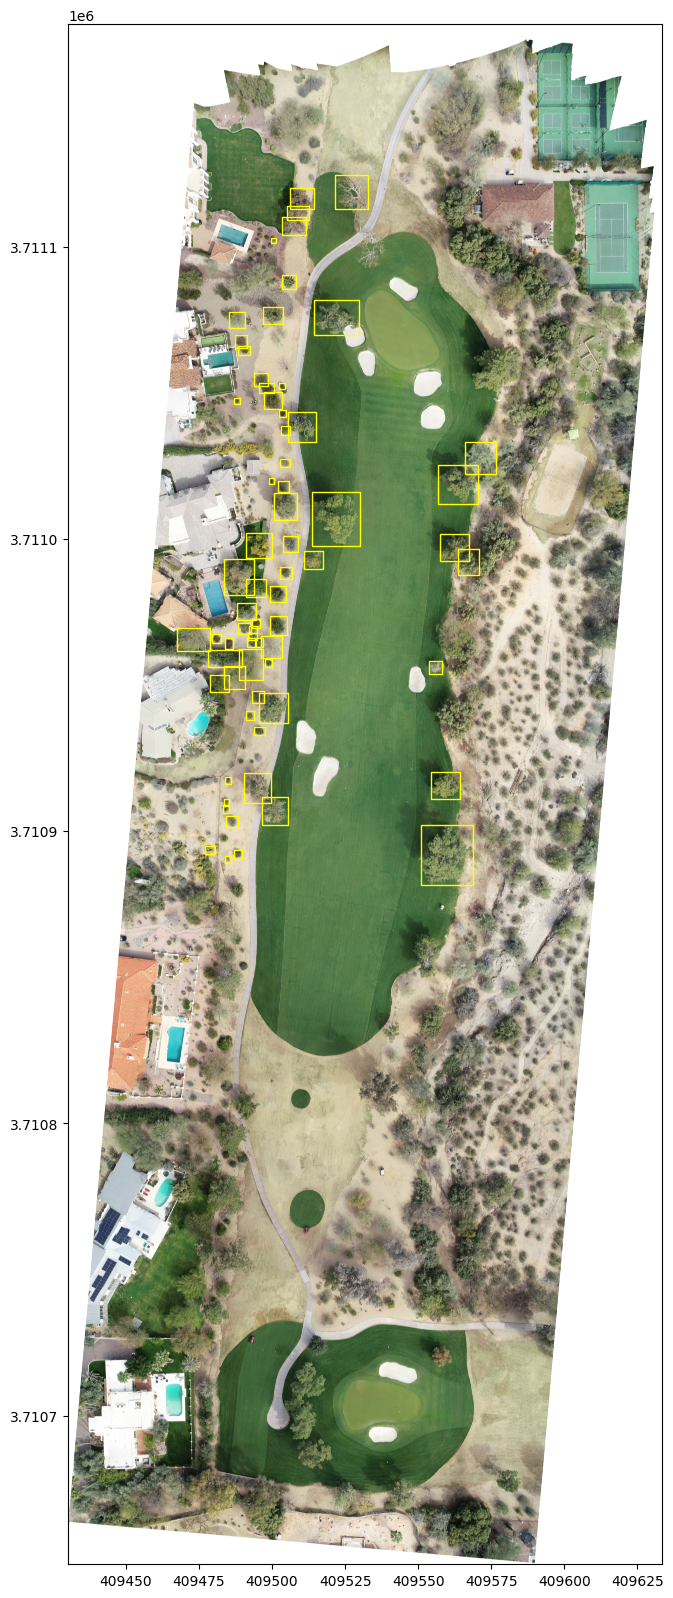

In [13]:
## Show shapefile overlayed on orthomosaic

# Open the GeoTIFF file
with rasterio.open(train_image_path) as src:
    fig, ax = plt.subplots(figsize=(20, 20))
    show(src, ax=ax)

    # Read the shapefile
    shapefile = gpd.read_file(shp_path)

    # Plot the shapefile on top of the GeoTIFF
    shapefile.plot(ax=ax, facecolor='none', edgecolor='yellow')

plt.show()

In [14]:
##Convert .shp (shapefile) to annoation that can be ingested by DeepForest
df = shapefile_to_annotations(shapefile=shp_path, rgb=train_image_path, geometry_type='bbox', savedir=savedir)

In [17]:
#Write training annotation dataframe to csv file
#ATTENTION!!! You need to change the path to YOUR datastore directory. Change .../jgillan to your Cyverse username
savedir = "/data-store/iplant/home/jgillan/media"
df.to_csv(os.path.join(savedir, "labels_pixel_coords.csv"), index=False)

In [15]:
#Show the annotation
df

image_path  xmin   ymin  xmax   ymax label
0   hole_17_ortho_utm.tif  3655   8704  3899   8969  Tree
1   hole_17_ortho_utm.tif  4011   8958  4332   9254  Tree
2   hole_17_ortho_utm.tif  3502   7961  3894   8424  Tree
3   hole_17_ortho_utm.tif  3013   8653  3461   9075  Tree
4   hole_17_ortho_utm.tif  3604   9223  3802   9427  Tree
..                    ...   ...    ...   ...    ...   ...
63  hole_17_ortho_utm.tif  2323  13966  2486  14108  Tree
64  hole_17_ortho_utm.tif  2823  14037  2954  14179  Tree
65  hole_17_ortho_utm.tif  2660  14139  2762  14250  Tree
66  hole_17_ortho_utm.tif  2641  13169  2736  13280  Tree
67  hole_17_ortho_utm.tif  2633  13272  2739  13398  Tree

[68 rows x 6 columns]

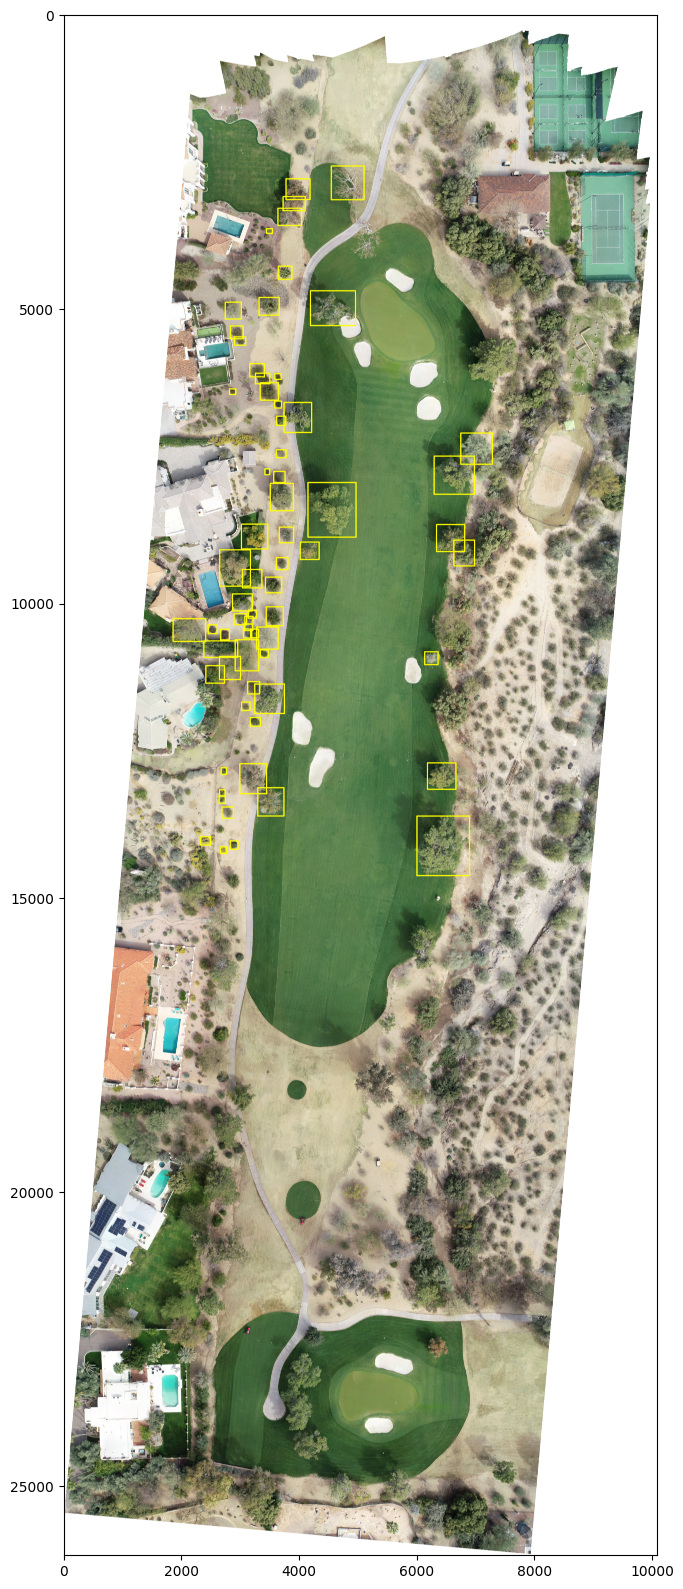

In [16]:
## Display the annotation on the orthomosaic

rasterio_src = rasterio.open(train_image_path)

image = rasterio_src.read()
image = numpy.rollaxis(image, 0, 3)

fig = plot_predictions(image, df, color=(255, 255, 0), thickness=20)
plt.figure(figsize=(20, 20))
plt.imshow(fig)

In [18]:
##This will split a large georeferenced image (and it's labels) into smaller pieces. This prevents running out of memory.
annotation_path = os.path.join(savedir, "labels_pixel_coords.csv")

#create a directory where the smaller images will be stored
crop_dir = os.path.join(savedir, 'train_data')

# Do the split and write out the cropped images as .png files. 
#Also write a new annotation table (csv) that lists all of the label coordinates and the cropped image they belong to. 
output_crops = split_raster(path_to_raster=train_image_path,
                            annotations_file=annotation_path,
                            base_dir=crop_dir,
                            patch_size=1100,  #1100x1100 pixels
                            patch_overlap=0.25, #cropped image overlap. This is useful because label boxes may be on the edge of cropped images.
                            allow_empty=False)

print(f"Number of tree crown annotations: {len(output_crops)}")
output_crops

Number of tree crown annotations: 81


image_path  xmin  ymin  xmax  ymax label
26   hole_17_ortho_utm_76.png   798   465   950   615  Tree
56   hole_17_ortho_utm_76.png   202   360   756   746  Tree
52   hole_17_ortho_utm_77.png   759   334  1074   631  Tree
61   hole_17_ortho_utm_79.png  1018   419  1100   532  Tree
66   hole_17_ortho_utm_79.png   991   794  1086   905  Tree
..                        ...   ...   ...   ...   ...   ...
10  hole_17_ortho_utm_234.png   551   410  1030   869  Tree
39  hole_17_ortho_utm_237.png   351    98   577   316  Tree
57  hole_17_ortho_utm_239.png   397   336   881   785  Tree
8   hole_17_ortho_utm_264.png   139   505   674  1035  Tree
11  hole_17_ortho_utm_266.png    21   675   373  1100  Tree

[81 rows x 6 columns]

In [29]:
#Create a variable that defines the path of new annotation table
#base_name, _ = os.path.splitext(image_name)
#csv_name = base_name + ".csv"
#annotation_table = os.path.join(crop_dir, csv_name)

### Split annotation data into training and validation

In [19]:
#identify all of the cropped images as an array
image_paths = output_crops.image_path.unique()

#Of the unique cropped image paths, randomly select 25% of them
validation_paths = numpy.random.choice(image_paths, int(len(image_paths)*0.25))

#Get the individual tree annotation from the 25% cropped images
validation_annotations = output_crops.loc[output_crops.image_path.isin(validation_paths)]

#Get the individual tree annotations from the remaining 75% cropped images
train_annotations = output_crops.loc[~output_crops.image_path.isin(validation_paths)]

#Print out the number of training and testing tree crown annotations
train_annotations.head()
print("There are {} training crown annotations".format(train_annotations.shape[0]))
print("There are {} test crown annotations".format(validation_annotations.shape[0]))

There are 66 training crown annotations
There are 15 test crown annotations


In [20]:
## Write training and validation annotations to separate csv files

#save to file and create the file dir
training_file= os.path.join(crop_dir,"train.csv")
validation_file= os.path.join(crop_dir,"valid.csv")
#Write window annotations file without a header row, same location as the "base_dir" above.
train_annotations.to_csv(training_file,index=False)
validation_annotations.to_csv(validation_file,index=False)

## Train 

In [26]:
##Set parameters for the training run

#Define the pre-trained model
model = main.deepforest()

model.config['gpus'] = '-1' #move to GPU and use all the GPU resources

#model.config["save-snapshot"] = False
#model.config["train"]["fast_dev_run"] = True

#The annotation table
model.config["train"]["csv_file"] = training_file
#The directory where the training imagery is located
model.config["train"]["root_dir"] = os.path.dirname(training_file)

model.config["score_thresh"] = 0.4
model.config["train"]['epochs'] = 4

model.config["validation"]["csv_file"] = validation_file
model.config["validation"]["root_dir"] = os.path.dirname(validation_file)


model.create_trainer()

model.use_release()


Reading config file: /opt/conda/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [27]:
##TRAIN THE MODEL!
#You can watch the GPU usage by using nvtop (sudo apt install nvtop)
start_time = time.time()
model.trainer.fit(model)
print(f"--- Training on GPU: {(time.time() - start_time):.2f} seconds ---")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name       | Type                  | Params
-----------------------------------------------------
0 | model      | RetinaNet             | 32.1 M
1 | iou_metric | IntersectionOverUnion | 0     
2 | mAP_metric | MeanAveragePrecision  | 0     
-----------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:144: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/opt/conda/lib/python3.11/site-packages/deepforest/evaluate.py:193: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(results)
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 26/26 [00:12<00:00,  2.15it/s, v_num=2]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:07<00:00,  3.40it/s, v_num=2]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:07<00:00,  3.66it/s, v_num=2]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:07<00:00,  3.65it/s, v_num=2]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:09<00:00,  2.88it/s, v_num=2]     

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 26/26 [00:09<00:00,  2.88it/s, v_num=2]
--- Training on GPU: 47.59 seconds ---


In [39]:
save_dir = os.path.join(train_image_dir, 'pred_result')
os.makedirs(save_dir, exist_ok=True)
results = model.evaluate(training_file, os.path.dirname(training_file), iou_threshold = 0.4, savedir= save_dir)

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:144: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 26/26 [00:06<00:00,  4.30it/s]


In [40]:
save_dir = os.path.join(train_image_dir, 'valid_result')
os.makedirs(save_dir, exist_ok=True)
results = model.evaluate(validation_file, os.path.dirname(validation_file), iou_threshold = 0.4, savedir= save_dir)

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:144: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]


/opt/conda/lib/python3.11/site-packages/deepforest/IoU.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  iou_df = pd.concat(iou_df)


In [41]:
results

{'results':   prediction_id  truth_id       IoU     score  xmin  xmax  ymin  ymax  \
 0             3         0  0.039966  0.203777   262   535   756  1043   
 0             3         0  0.556731  0.286322   680   927   150   374   
 1             0         1  0.000000  0.360183   774  1021   313   492   
 2             1         2  0.693306  0.317040   335   443   579   673   
 0             5         0  0.603797  0.293284   412   627   276   463   
 1             3         1  0.724986  0.357832     0   125   465   615   
 2             1         2  0.755084  0.413433   186   333   539   720   
 3             0         3  0.804035  0.439437   861   993   891  1023   
 4             6         4  0.425766  0.265574   569   714   536   689   
 5             4         5  0.000000  0.299946   693   830   539   684   
 6             2         6  0.825716  0.388040   656   790   216   352   
 7            10         7  0.660766  0.194448   588   730   450   563   
 8             7         8 

In [42]:
results['results']

prediction_id  truth_id       IoU     score  xmin  xmax  ymin  ymax  \
0             3         0  0.039966  0.203777   262   535   756  1043   
0             3         0  0.556731  0.286322   680   927   150   374   
1             0         1  0.000000  0.360183   774  1021   313   492   
2             1         2  0.693306  0.317040   335   443   579   673   
0             5         0  0.603797  0.293284   412   627   276   463   
1             3         1  0.724986  0.357832     0   125   465   615   
2             1         2  0.755084  0.413433   186   333   539   720   
3             0         3  0.804035  0.439437   861   993   891  1023   
4             6         4  0.425766  0.265574   569   714   536   689   
5             4         5  0.000000  0.299946   693   830   539   684   
6             2         6  0.825716  0.388040   656   790   216   352   
7            10         7  0.660766  0.194448   588   730   450   563   
8             7         8  0.000000  0.247610   596   735   321   452   
0             0         0  0.701461  0.421167   333   733     0   278   
1             1         1  0.771234  0.310560   139   239   331   412   
0             0         0  0.800046  0.370074   338   570   144   367   
1             1         1  0.794708  0.332831    12   354   675   977   
0             1         0  0.751998  0.430149   133   423   158   479   
1             0         1  0.748189  0.432498    36   168   891  1023   
2          None         2  0.000000       NaN     0   336   502   878   
0             0         0  0.384826  0.318799   551  1030   410   869   
0             0         0  0.281069  0.193934   139   674   505  1035   

  predicted_label true_label                 image_path  match  
0            Tree       Tree  hole_17_ortho_utm_101.png  False  
0            Tree       Tree  hole_17_ortho_utm_103.png   True  
1            Tree       Tree  hole_17_ortho_utm_103.png  False  
2            Tree       Tree  hole_17_ortho_utm_103.png   True  
0            Tree       Tree  hole_17_ortho_utm_108.png   True  
1            Tree       Tree  hole_17_ortho_utm_108.png   True  
2            Tree       Tree  hole_17_ortho_utm_108.png   True  
3            Tree       Tree  hole_17_ortho_utm_108.png   True  
4            Tree       Tree  hole_17_ortho_utm_108.png   True  
5            Tree       Tree  hole_17_ortho_utm_108.png  False  
6            Tree       Tree  hole_17_ortho_utm_108.png   True  
7            Tree       Tree  hole_17_ortho_utm_108.png   True  
8            Tree       Tree  hole_17_ortho_utm_108.png  False  
0            Tree       Tree  hole_17_ortho_utm_132.png   True  
1            Tree       Tree  hole_17_ortho_utm_132.png   True  
0            Tree       Tree  hole_17_ortho_utm_133.png   True  
1            Tree       Tree  hole_17_ortho_utm_133.png   True  
0            Tree       Tree  hole_17_ortho_utm_140.png   True  
1            Tree       Tree  hole_17_ortho_utm_140.png   True  
2             NaN       Tree  hole_17_ortho_utm_140.png  False  
0            Tree       Tree  hole_17_ortho_utm_234.png  False  
0            Tree       Tree  hole_17_ortho_utm_264.png  False

In [43]:
results['box_precision']

0.26908143939393936

In [44]:
results["box_recall"]

0.5138888888888888

In [45]:
results["class_recall"]

label  recall  precision  size
0      0     1.0        1.0    15

## Look at the prediction after model fine-tuning

In [47]:
#Set the path for a georeferenced image you want to predict tree crowns
#raster_path = get_data("/data-store/iplant/home/jgillan/media/1a_g2_ortho.tif")
raster_path = get_data("/data-store/iplant/home/jgillan/USGA/imagery_products/hole_17_ortho_utm.tif")

In [48]:
##Predict tree crowns on a georeferenced image
predicted_raster = model.predict_tile(raster_path, return_plot = True, patch_size=1000, patch_overlap=0.25, color=(255, 255, 0), thickness=20)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 490/490 [00:27<00:00, 17.77it/s]
2528 predictions in overlapping windows, applying non-max supression
1387 predictions kept after non-max suppression


/opt/conda/lib/python3.11/site-packages/deepforest/visualize.py:118: UserWarning: Input images must be channels last format [h, w, 3] not channels first [3, h, w], using np.rollaxis(image, 0, 3) to invert!
  warnings.warn("Input images must be channels last format [h, w, 3] not channels "


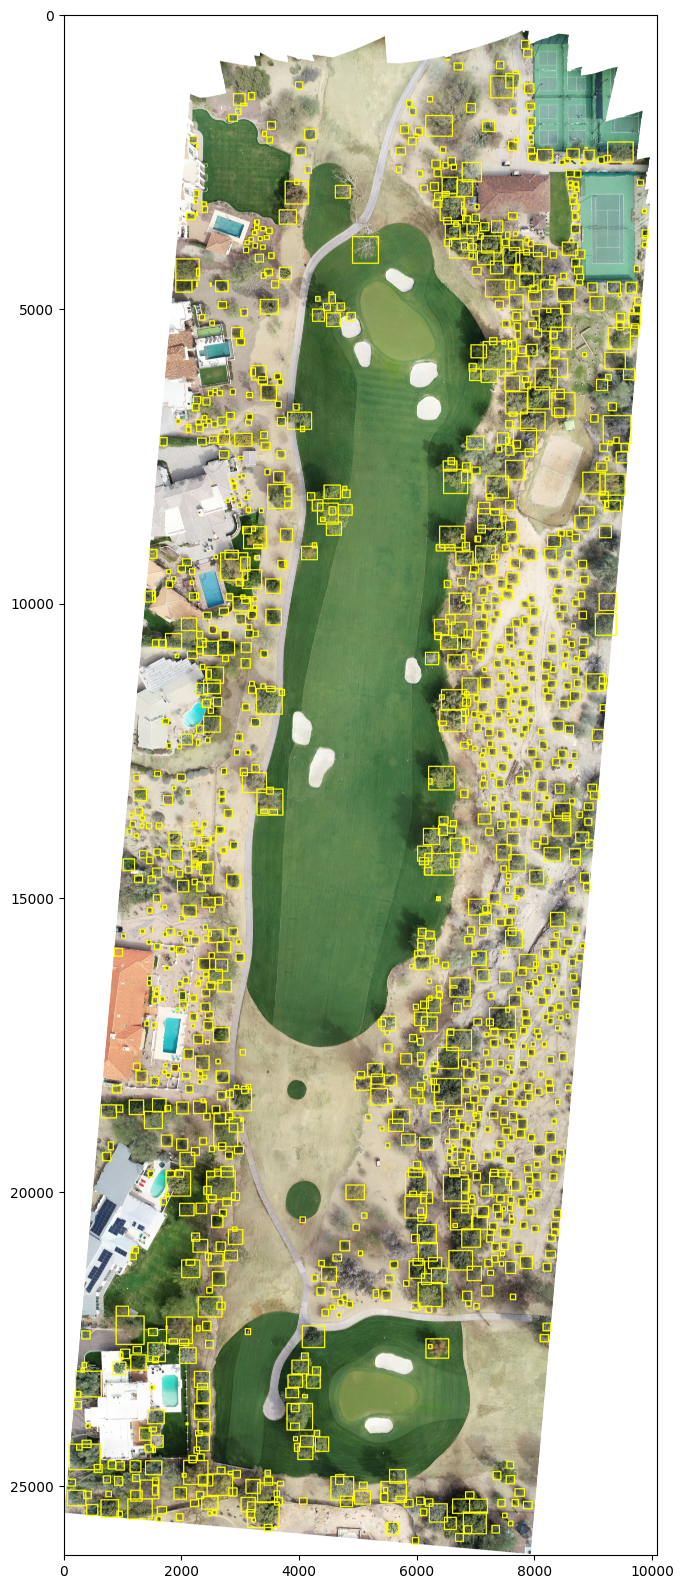

In [49]:
plt.figure(figsize=(20, 20))
plt.imshow(predicted_raster)
plt.show()